# Classifier Decision Tree

## Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from IPython.display import Image

## Dataframe

In [205]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Tratamento de Dados

* O Scikit-Learn não aceita missing-values e valores categóricos/bool;

In [206]:
titanic.shape

(891, 15)

In [207]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [208]:
titanic = titanic.drop_duplicates()
titanic.shape

(784, 15)

* Arrumando numeração do index:

In [209]:
titanic.tail()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
885,0,3,female,39.0,0,5,29.125,Q,Third,woman,False,NaN,Queenstown,no,False
887,1,1,female,19.0,0,0,30.000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.450,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.000,C,First,man,True,C,Cherbourg,yes,True
890,0,3,male,32.0,0,0,7.750,Q,Third,man,True,NaN,Queenstown,no,True


In [210]:
titanic.reset_index(drop=True, inplace=True)

* Valores Ausentes

In [211]:
titanic.isna().sum()

survived         0
pclass           0
sex              0
age            106
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           582
embark_town      2
alive            0
alone            0
dtype: int64

In [212]:
titanic_sem_na = titanic.dropna(axis=1)

* Dados Categóricos

- **survived** - se o passageiro sobreviveu ou não, ou seja, nossa target
- **pclass** - classe em que o passageiro estava (primeira, segunda, terceira)
- **sex** - genero do passageiro (masculino ou feminino)
- **sibsp** - quantidade de irmãos/esposos/esposas no navio (0 a 8)	
- **parch** - quantidade de pais/filhos a bordo
- **fare** - preço do ticket
- **class** - igual a pclass	
- **who** - se é homem, mulher ou criança
- **adult_male** - se é um homem adulto
- **alive** - igual a survived
- **alone** - se estava sozinho a bordo

* Survived e Alive são variáveis iguais:

In [213]:
titanic_sem_na.survived.value_counts()

survived
0    461
1    323
Name: count, dtype: int64

In [214]:
titanic_sem_na.alive.value_counts()

alive
no     461
yes    323
Name: count, dtype: int64

In [215]:
titanic_sem_na[['alive','survived','sibsp']].groupby(['alive','survived']).count()

,,sibsp
alive,survived,
no,0,461
yes,1,323


In [216]:
titanic_sem_na = titanic_sem_na.drop('alive',axis=1)

* pclass e class

In [217]:
titanic_sem_na['pclass'].unique()

array([3, 1, 2], dtype=int64)

In [218]:
titanic_sem_na['class'].unique()

['Third', 'First', 'Second']
Categories (3, object): ['First', 'Second', 'Third']

In [219]:
titanic_sem_na = titanic_sem_na.drop('pclass',axis=1)

* Outras variáveis

In [220]:
titanic_sem_na['sex'].unique()

array(['male', 'female'], dtype=object)

In [221]:
titanic_sem_na['sibsp'].unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [222]:
titanic_sem_na['parch'].unique()

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

In [223]:
titanic_sem_na['who'].unique()

array(['man', 'woman', 'child'], dtype=object)

In [224]:
titanic_encoded = pd.get_dummies(titanic_sem_na, columns=['class','who'], drop_first=True)

In [225]:
titanic_encoded.sex = titanic_encoded.sex.map({'female': 1, 'male':0})

* Mudando tipo de dados

In [226]:
titanic_encoded.head()

,survived,sex,sibsp,parch,fare,adult_male,alone,class_Second,class_Third,who_man,who_woman
0,0,0,1,0,7.2500,True,False,False,True,True,False
1,1,1,1,0,71.2833,False,False,False,False,False,True
2,1,1,0,0,7.9250,False,True,False,True,False,True
3,1,1,1,0,53.1000,False,False,False,False,False,True
4,0,0,0,0,8.0500,True,True,False,True,True,False


In [227]:
titanic_encoded.dtypes

survived          int64
sex               int64
sibsp             int64
parch             int64
fare            float64
adult_male         bool
alone              bool
class_Second       bool
class_Third        bool
who_man            bool
who_woman          bool
dtype: object

In [228]:
titanic_encoded.adult_male = titanic_encoded.adult_male.astype(int)
titanic_encoded.alone = titanic_encoded.alone.astype(int)
titanic_encoded.class_Second = titanic_encoded.class_Second.astype(int)
titanic_encoded.class_Third = titanic_encoded.class_Third.astype(int)
titanic_encoded.who_man = titanic_encoded.who_man.astype(int)
titanic_encoded.who_woman = titanic_encoded.who_woman.astype(int)

In [229]:
titanic_encoded.dtypes

survived          int64
sex               int64
sibsp             int64
parch             int64
fare            float64
adult_male        int32
alone             int32
class_Second      int32
class_Third       int32
who_man           int32
who_woman         int32
dtype: object

## `Árvore de Decisão de Classificação`

* Algoritmo GINI

* Fórmula GINI para cáculo de variáveis discreta (0 e 1):

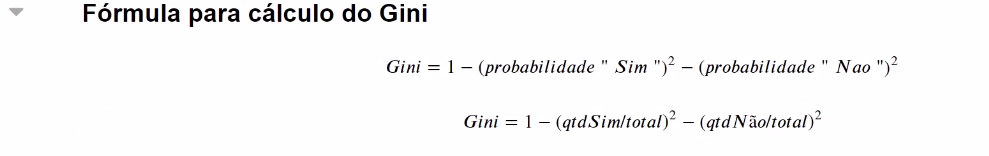

In [2]:
Image(filename='./pictures/gini.PNG')

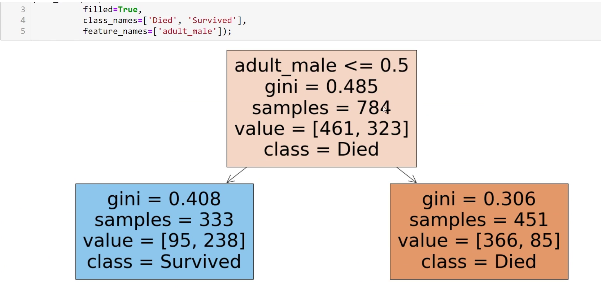

In [3]:
Image(filename='./pictures/example_1.PNG')

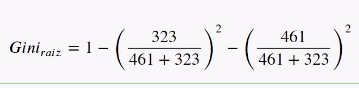

In [4]:
Image(filename='./pictures/example_2.PNG')

* Cálculo do Gini para variáveis contínuas:

Após tirar a média entre o valor 1 e valor 2:

* O MELHOR VALOR FOI PARA O 45, ONDE GINI = 0, ou seja, foi decidido o valor de quebra da variável;
* Como o datafram e é pequeno, apenas duas colunas é feito apenas uma pergunta (sobre o ticket), se ouvessem mais colunas o gini é calculado para cada uma delas e persistido o menor possível. 

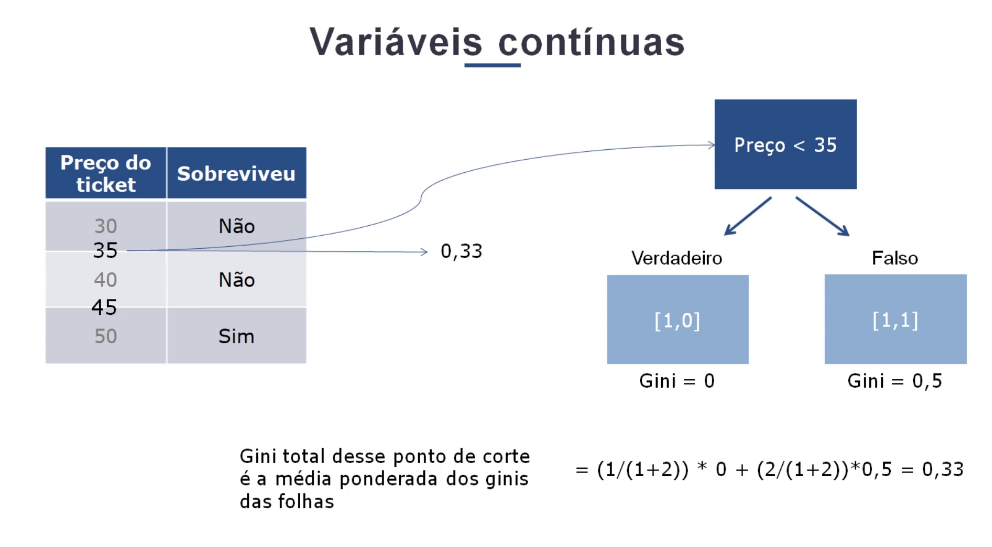

In [6]:
Image(filename='./pictures/gini_continuous_1.PNG')

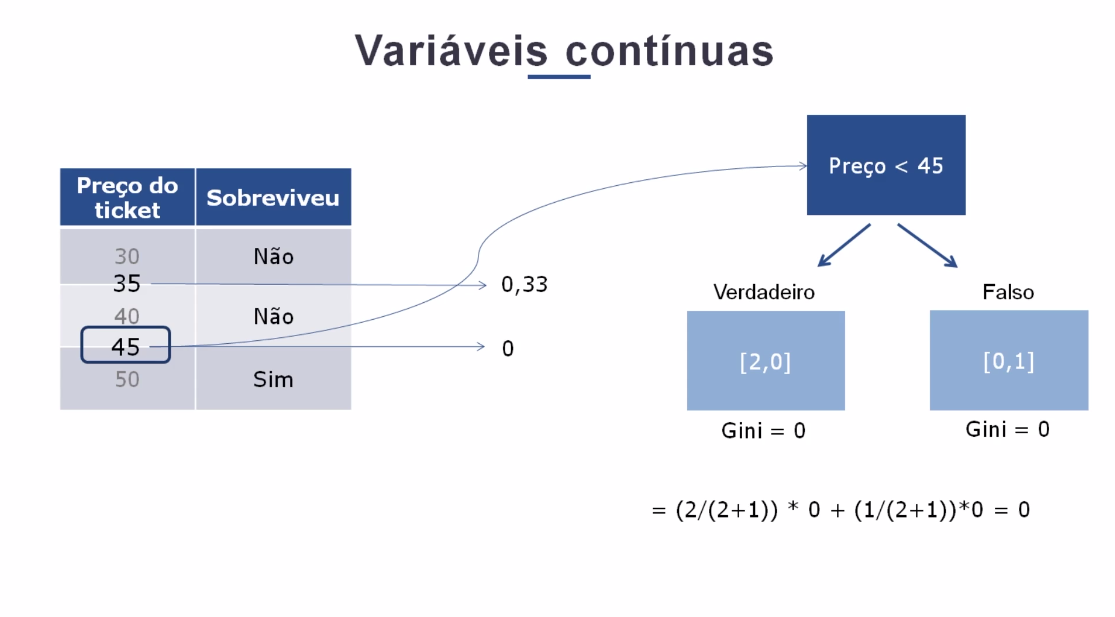

In [7]:
Image(filename='./pictures/gini_continuous_2.PNG')

* Separando Explicativas e Target

In [234]:
y = titanic_encoded.survived

In [235]:
X = titanic_encoded.drop('survived',axis=1)

* Separando em treino e teste

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

* Criando árvore

In [243]:
clf = DecisionTreeClassifier(random_state=100)
clf

DecisionTreeClassifier(random_state=100)

* Fit

In [244]:
clf = clf.fit(X_train,y_train)

* Plotando árvore

[Text(0.4232678282009725, 0.96875, 'who_man <= 0.5\ngini = 0.488\nsamples = 548\nvalue = [317, 231]\nclass = Died'),
 Text(0.22082658022690438, 0.90625, 'class_Third <= 0.5\ngini = 0.372\nsamples = 231\nvalue = [57, 174]\nclass = Survived'),
 Text(0.12641815235008103, 0.84375, 'fare <= 28.856\ngini = 0.089\nsamples = 129\nvalue = [6, 123]\nclass = Survived'),
 Text(0.09724473257698542, 0.78125, 'fare <= 28.231\ngini = 0.16\nsamples = 57\nvalue = [5, 52]\nclass = Survived'),
 Text(0.08427876823338736, 0.71875, 'fare <= 26.125\ngini = 0.133\nsamples = 56\nvalue = [4, 52]\nclass = Survived'),
 Text(0.0713128038897893, 0.65625, 'fare <= 25.965\ngini = 0.159\nsamples = 46\nvalue = [4, 42]\nclass = Survived'),
 Text(0.03889789303079417, 0.59375, 'fare <= 13.25\ngini = 0.108\nsamples = 35\nvalue = [2, 33]\nclass = Survived'),
 Text(0.02593192868719611, 0.53125, 'fare <= 12.825\ngini = 0.198\nsamples = 18\nvalue = [2, 16]\nclass = Survived'),
 Text(0.012965964343598054, 0.46875, 'gini = 0.0\ns

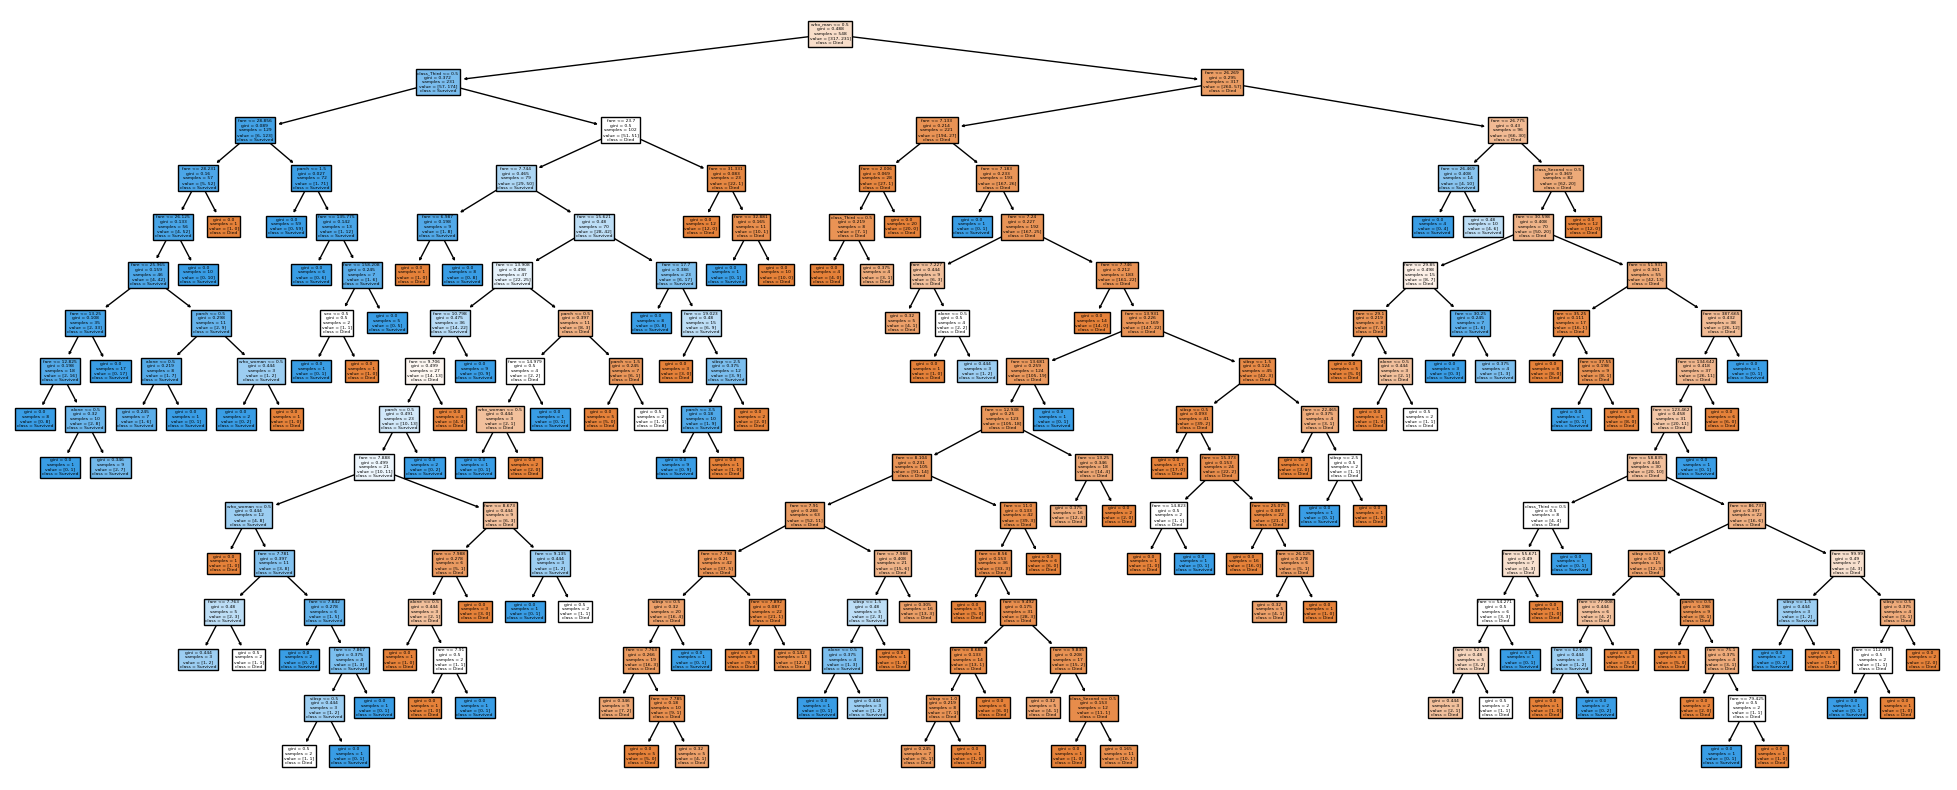

In [245]:
plt.figure(figsize=(25, 10))
plot_tree(clf,
          filled=True,
          class_names=['Died', 'Survived'],
          feature_names=X.columns.tolist())

* Predict

In [246]:
predict = clf.predict(X_test)

In [247]:
predict_train = clf.predict(X_train)

In [248]:
predict

array([1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

* Matriz de Confusão

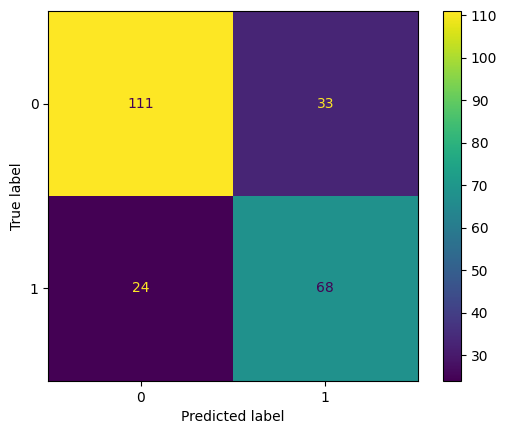

In [249]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

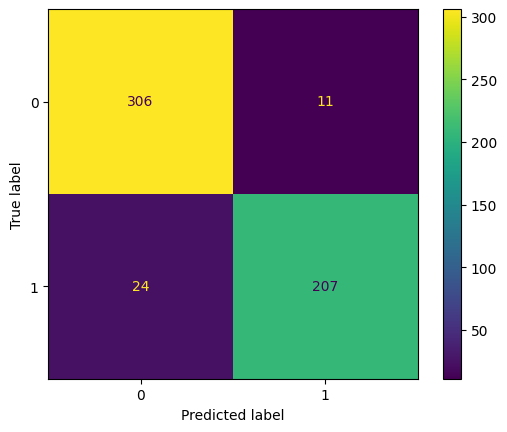

In [250]:
cm = confusion_matrix(y_train, predict_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

* Acurácia

In [251]:
accuracy_score(y_test, predict)

0.7584745762711864

In [252]:
accuracy_score(y_train, predict_train)

0.9361313868613139

#### Pre-Prunning

* Alterar número mín/máx de amostras por folha;
* Alterar valor mín/máx da profundidade da árvore.

In [253]:
clf = DecisionTreeClassifier(max_depth=8, min_samples_leaf=8, random_state=100)
clf = clf.fit(X_train,y_train)
predict = clf.predict(X_test)
accuracy_score(y_test, predict)

0.7754237288135594

* Ávore diminuiu:

[Text(0.4807692307692308, 0.9444444444444444, 'who_man <= 0.5\ngini = 0.488\nsamples = 548\nvalue = [317, 231]\nclass = Died'),
 Text(0.2564102564102564, 0.8333333333333334, 'class_Third <= 0.5\ngini = 0.372\nsamples = 231\nvalue = [57, 174]\nclass = Survived'),
 Text(0.15384615384615385, 0.7222222222222222, 'fare <= 28.856\ngini = 0.089\nsamples = 129\nvalue = [6, 123]\nclass = Survived'),
 Text(0.10256410256410256, 0.6111111111111112, 'who_woman <= 0.5\ngini = 0.16\nsamples = 57\nvalue = [5, 52]\nclass = Survived'),
 Text(0.07692307692307693, 0.5, 'gini = 0.0\nsamples = 10\nvalue = [0, 10]\nclass = Survived'),
 Text(0.1282051282051282, 0.5, 'fare <= 25.965\ngini = 0.19\nsamples = 47\nvalue = [5, 42]\nclass = Survived'),
 Text(0.07692307692307693, 0.3888888888888889, 'fare <= 13.25\ngini = 0.124\nsamples = 30\nvalue = [2, 28]\nclass = Survived'),
 Text(0.05128205128205128, 0.2777777777777778, 'fare <= 12.825\ngini = 0.198\nsamples = 18\nvalue = [2, 16]\nclass = Survived'),
 Text(0.025

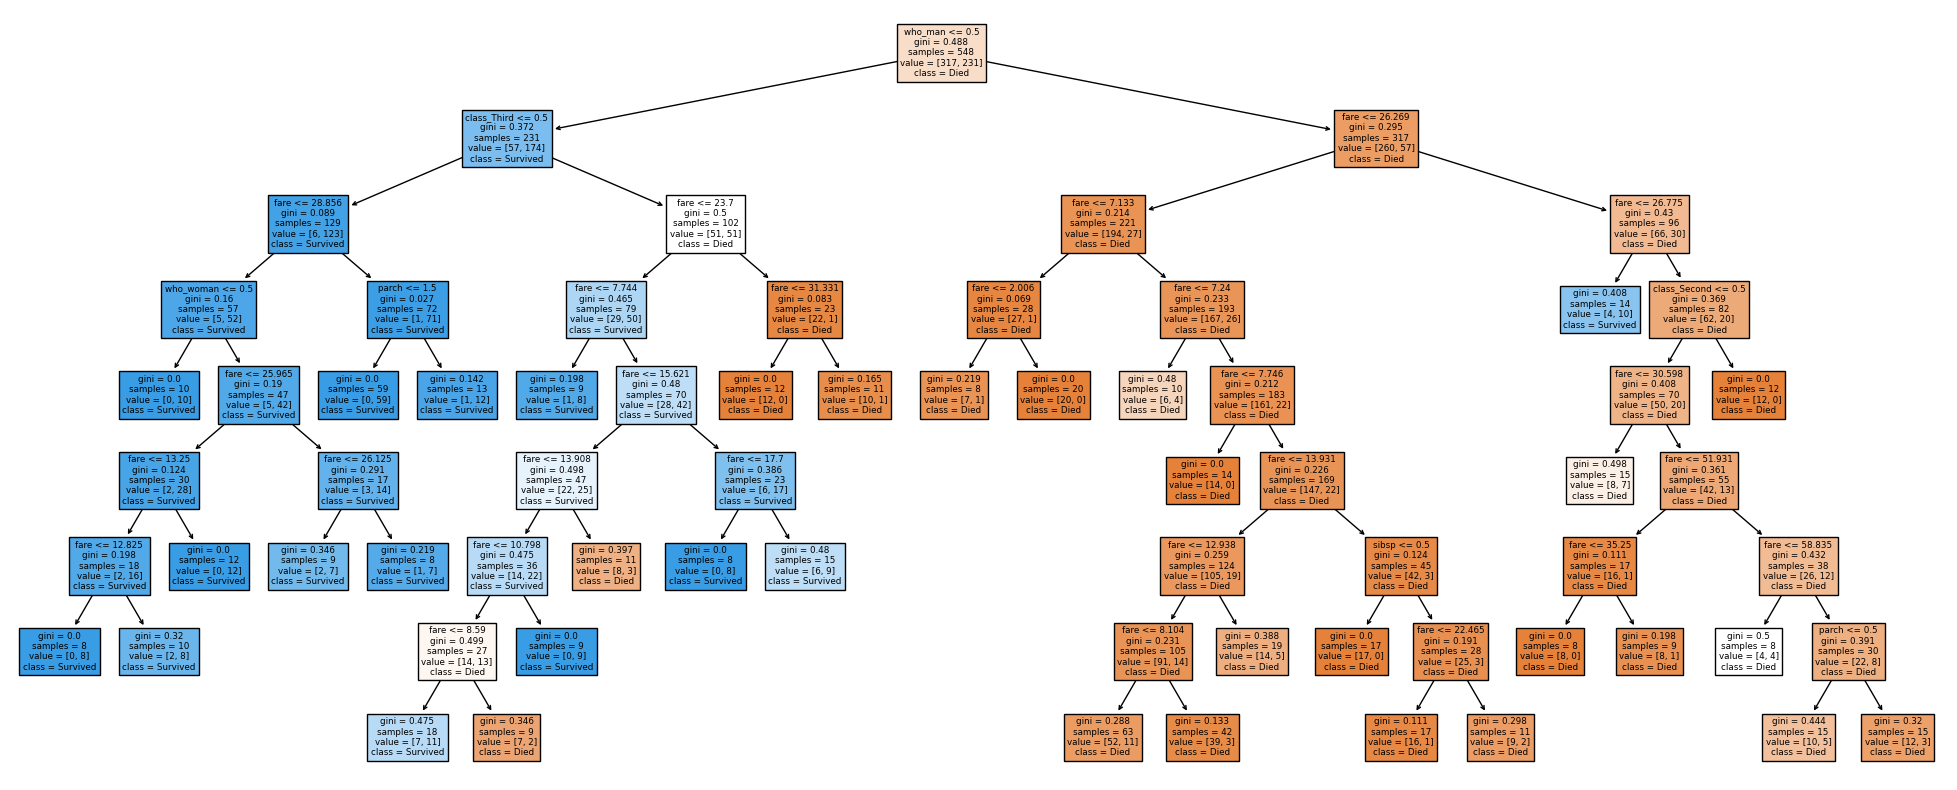

In [255]:
plt.figure(figsize=(25, 10))
plot_tree(clf,
          filled=True,
          class_names=['Died', 'Survived'],
          feature_names=X.columns.tolist())

#### Post-Pruning

In [256]:
clf = DecisionTreeClassifier(random_state=100)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [258]:
ccp_alphas

array([0.00000000e+00, 2.76487503e-05, 6.51720542e-05, 6.51720542e-05,
       1.14848655e-04, 1.21654501e-04, 1.21654501e-04, 1.21654501e-04,
       1.41640598e-04, 1.62206002e-04, 3.04136253e-04, 3.11606266e-04,
       3.91032325e-04, 3.91032325e-04, 4.05515004e-04, 4.05515004e-04,
       4.42380004e-04, 5.21376434e-04, 5.41915505e-04, 6.08272506e-04,
       6.08272506e-04, 7.60340633e-04, 8.70046924e-04, 8.99736415e-04,
       9.38477581e-04, 9.73236010e-04, 1.01378751e-03, 1.04275287e-03,
       1.08137334e-03, 1.12253926e-03, 1.30344108e-03, 1.36861314e-03,
       1.45308727e-03, 1.57750242e-03, 1.61152716e-03, 1.66840459e-03,
       1.71747531e-03, 1.74547763e-03, 1.76952002e-03, 1.80718643e-03,
       1.81073008e-03, 1.86228724e-03, 2.03239438e-03, 2.83054723e-03,
       3.24412003e-03, 3.28467153e-03, 3.97287163e-03, 3.98487099e-03,
       4.21233046e-03, 9.25243996e-03, 2.25877660e-02, 4.27523164e-02,
       1.60365178e-01])

In [259]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [260]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

In [267]:
train_scores[40:]

[0.8832116788321168,
 0.8813868613138686,
 0.8795620437956204,
 0.8795620437956204,
 0.8777372262773723,
 0.8759124087591241,
 0.8704379562043796,
 0.8503649635036497,
 0.8412408759124088,
 0.8302919708029197,
 0.791970802919708,
 0.791970802919708,
 0.5784671532846716]

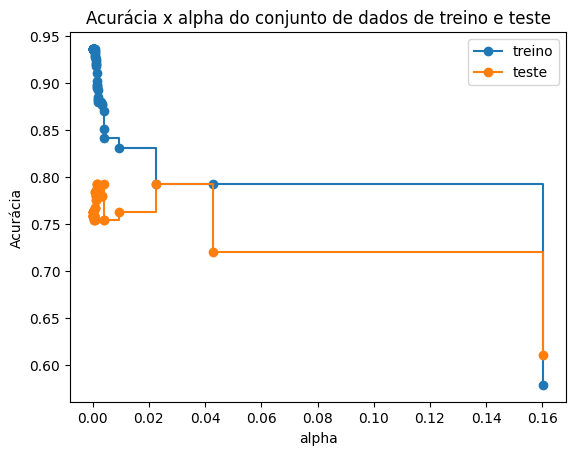

In [268]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste")
ax.plot(ccp_alphas, train_scores, marker='o', label="treino",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

* Conclusão:
O melhor valor de ccp-alpha é o ponto de equilíbrio entre a acurácia de treino e teste `(x=0.02, y=0.8)`.
* Registrado abaixo na linha de índice `50`:

In [269]:
pd.DataFrame({'alpha': ccp_alphas.tolist(), 'score': test_scores})

,alpha,score
0,0.000000,0.762712
1,0.000028,0.762712
2,0.000065,0.762712
3,0.000065,0.762712
4,0.000115,0.762712
5,0.000122,0.758475
6,0.000122,0.758475
7,0.000122,0.758475
8,0.000142,0.758475
9,0.000162,0.758475


* Agora que obtivemos o valor perfeito para o `ccp-alpha` podemos passar como parâmetro para a `DecisionTreeClassifier`:

In [272]:
clf_post_pruning = DecisionTreeClassifier(random_state=100, ccp_alpha=0.022588)

In [273]:
clf_post_pruning.fit(X_train, y_train)
predict = clf_post_pruning.predict(X_test)

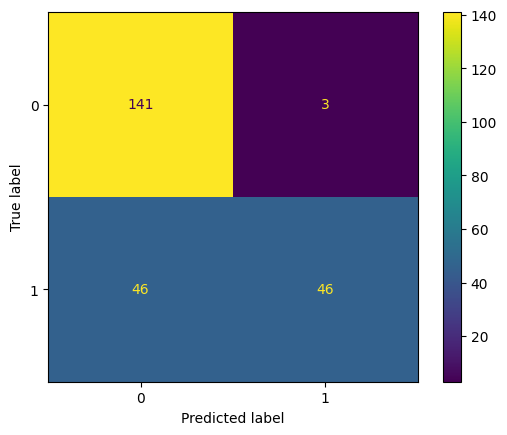

In [274]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

In [275]:
accuracy_score(y_test, predict)

0.7923728813559322

* Como ficou a árvore `post-pruning`:

[Text(0.6, 0.8333333333333334, 'who_man <= 0.5\ngini = 0.488\nsamples = 548\nvalue = [317, 231]\nclass = Died'),
 Text(0.4, 0.5, 'class_Third <= 0.5\ngini = 0.372\nsamples = 231\nvalue = [57, 174]\nclass = Survived'),
 Text(0.2, 0.16666666666666666, 'gini = 0.089\nsamples = 129\nvalue = [6, 123]\nclass = Survived'),
 Text(0.6, 0.16666666666666666, 'gini = 0.5\nsamples = 102\nvalue = [51, 51]\nclass = Died'),
 Text(0.8, 0.5, 'gini = 0.295\nsamples = 317\nvalue = [260, 57]\nclass = Died')]

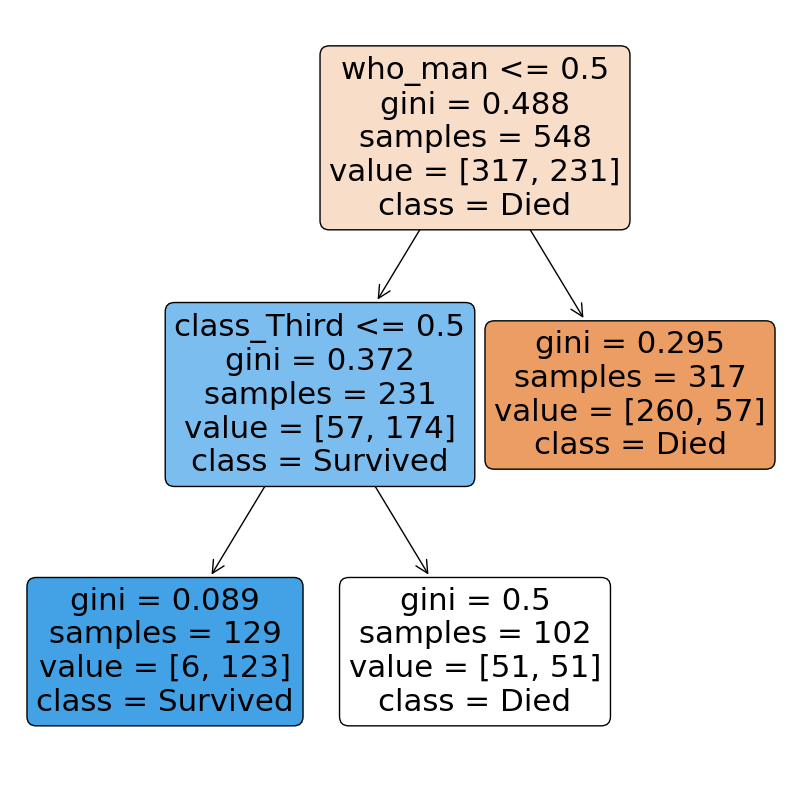

In [277]:
plt.figure(figsize=[10,10])
plot_tree(clf_post_pruning,
         filled=True,
         rounded=True,
         class_names=['Died', 'Survived'],
         feature_names=X_train.columns.to_list())